<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MGE-Sst"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/MGE-Sst/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


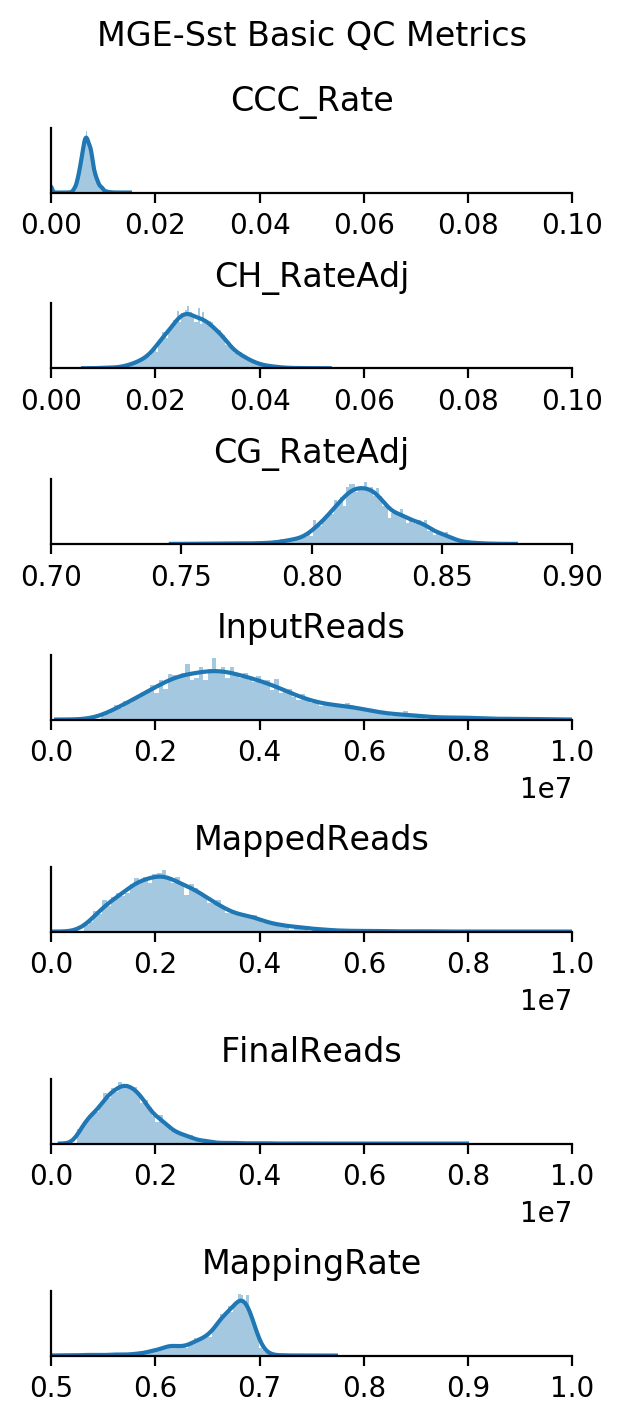

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

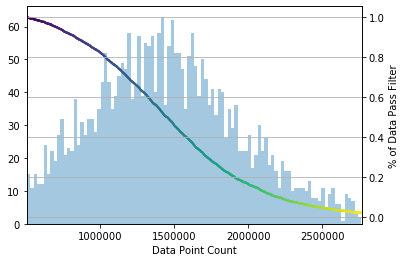

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2931/2931 (100.0%)
CG_RateAdj passed 2931/2931 (100.0%)
CH_RateAdj passed 2931/2931 (100.0%)
FinalReads passed 2931/2931 (100.0%)
MappingRate passed 2931/2931 (100.0%)
Overall passed 2931/2931 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 43
171207 59
171212 5
171213 52
171214 4
171219 3
180104 88
180109 14
180110 11
180111 2
180119 61
180122 40
180123 48
180129 39
180130 66
180205 43
180206 42
180208 12
180212 6
180213 60
180220 37
180222 30
180226 54
180227 46
180305 58
180306 67
180312 54
180313 6
180319 3
180320 27
180326 26
180329 23
180402 25
180403 32
180405 15
180409 59
180410 54
180412 54
180416 59
180417 29
180419 45
180423 48
180424 22
180426 55
180430 29
180501 41
180514 29
180529 39
180605 48
180612 59
180806 2
180917 3
181002 52
181008 33
181009 25
181015 5
181016 6
181022 37
181023 36
181204 3
181206 2
181210 70
181218 11
181220 22
190108 35
190117 33
190122 64
190124 60
190131 30
190205 73
190207 2
190212 53
190214 76
190219 38
190305 67
190307 39
190625 24
190627 36
190711 72
190716 51


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 334 87.0%
ad002 380 99.0%
ad004 415 108.1%
ad006 385 100.3%
ad007 353 91.9%
ad008 361 94.0%
ad010 369 96.1%
ad012 334 87.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_0,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.008198,0.822633,0.821166,0.041640,0.033718,1626504.0,4407752,2892347.0,10E,...,8.002170,8.983358,4.595703,14.504827,MGE-Sst,-23.368460,-1.151200,-34.021153,-19.429447,True
10E_M_1338,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.007324,0.814799,0.813433,0.036182,0.029071,1703622.0,4685660,3101242.0,10E,...,7.241936,11.137588,8.103620,27.121871,MGE-Sst,-22.636858,-2.069258,-16.735910,-23.776941,True
10E_M_1518,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007294,0.818669,0.817337,0.036374,0.029293,1972895.0,5551200,3483428.0,10E,...,6.966098,8.831718,0.669721,20.817461,MGE-Sst,-21.747980,-1.212093,-24.359495,-20.333471,True
10E_M_1528,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008194,0.829654,0.828246,0.040873,0.032949,1822062.0,5265826,3262298.0,10E,...,6.738061,9.175767,0.570977,21.435122,MGE-Sst,-21.531567,-1.288252,-23.112445,-19.672825,True
10E_M_1562,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007563,0.821367,0.820006,0.040022,0.032707,1995603.0,6161182,3908235.0,10E,...,6.668368,9.140317,0.630920,21.457764,MGE-Sst,-21.806568,-1.288683,-23.222587,-20.116938,True
10E_M_1647,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007440,0.790474,0.788904,0.038740,0.031535,2150275.0,6889012,4520780.0,10E,...,6.948688,11.420465,8.618593,27.466334,MGE-Sst,-22.541487,-2.493625,-17.339772,-22.936582,True
10E_M_1662,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007350,0.793791,0.792264,0.038327,0.031206,1042033.0,2630796,1676045.0,10E,...,7.132752,11.444122,8.642182,27.394147,MGE-Sst,-22.627964,-2.459516,-17.003114,-22.976922,True
10E_M_1700,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008265,0.798338,0.796658,0.040881,0.032888,1681721.0,4409024,2943458.0,10E,...,7.008102,11.568656,8.809577,27.480035,MGE-Sst,-22.418819,-2.696071,-17.617632,-22.607118,True
10E_M_1744,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008478,0.819280,0.817734,0.042130,0.033940,1835698.0,6121420,3926967.0,10E,...,6.612427,9.348854,0.675771,21.636486,MGE-Sst,-21.739853,-1.382250,-22.960700,-20.401501,True
